In [1]:
!nvidia-smi

Sun Mar 30 11:00:38 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A800 80GB PCIe          Off | 00000000:4F:00.0 Off |                    0 |
| N/A   35C    P0              50W / 300W |     18MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# 基本SFT

##数据

In [2]:
from datasets import load_dataset 

# 加载本地human-eval数据集
# 假设数据集在本地的路径为./human-eval
dataset = load_dataset("json", data_files="./human-eval/data/human-eval-v2-20210705.jsonl")
dataset

DatasetDict({
    train: Dataset({
        features: ['task_id', 'prompt', 'entry_point', 'canonical_solution', 'test'],
        num_rows: 164
    })
})

In [1]:
from datasets import load_dataset 

dataset = load_dataset("json", data_files="./human-eval/data/human-eval-v2-20210705.jsonl",split='train')
dataset,print("#"+dataset['task_id'][0]+'\n'+dataset['prompt'][0]+'\n'+dataset['canonical_solution'][0]+'\n')

/home/shichaoxue/anaconda3/envs/graduate/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#HumanEval/0
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """

    for idx, elem in enumerate(numbers):
        for idx2, elem2 in enumerate(numbers):
            if idx != idx2:
                distance = abs(elem - elem2)
                if distance < threshold:
                    return True

    return False




(Dataset({
     features: ['task_id', 'prompt', 'entry_point', 'canonical_solution', 'test'],
     num_rows: 164
 }),
 None)

In [15]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/shichaoxue/models/Qwen2.5-0.5B-Instruct")
tokenizer

Qwen2TokenizerFast(name_or_path='/home/shichaoxue/models/Qwen2.5-0.5B-Instruct', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False,

In [19]:
for prompt,canonical_solution in list(zip(dataset['prompt'],dataset['canonical_solution']))[:1]:
    message=[
        {
            "role":"system",
            "content":"you are a helpful code assistant",
        },
        {
            "role":"user",
            "content":prompt,
        },
        {
            "role":"assistant",
            "content":canonical_solution,
        },
    ]
    print(message)
    print(tokenizer.apply_chat_template(message,tokenize=False))
        

[{'role': 'system', 'content': 'you are a helpful code assistant'}, {'role': 'user', 'content': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n'}, {'role': 'assistant', 'content': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold:\n                    return True\n\n    return False\n'}]
<|im_start|>system
you are a helpful code assistant<|im_end|>
<|im_start|>user
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers cl

In [ ]:
import json 
with open('train.jsonl','w') as fp:
    for item in dataset:
        message=[
            {
                "role":"system",
                "content":"you are a helpful code assistant",
            },
            {
                "role":"user",
                "content":item['prompt'],
            },
            {
                "role":"assistant",
                "content":item['canonical_solution'],
            },
        ]
        # fp.write(json.dumps({"message":message},ensure_ascii=False)+'\n')


## 模型准备

In [2]:
import torch
import os
from transformers import AutoTokenizer,AutoModelForCausalLM ,BitsAndBytesConfig

os.environ["CUDA_VISIBLE_DEVICES"] = "3,"

MODEL_PATH="/home/shichaoxue/models/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    # quantization_config=BitsAndBytesConfig(load_in_8bit=True),
    device_map="auto",
    )


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
!nvidia-smi

Sun Mar 30 11:01:05 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A800 80GB PCIe          Off | 00000000:4F:00.0 Off |                    0 |
| N/A   36C    P0              50W / 300W |     18MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [30]:
!cat {MODEL_PATH}/tokenizer_config.json | grep chat_template

  "chat_template": "{%- if tools %}\n    {{- '<|im_start|>system\\n' }}\n    {%- if messages[0]['role'] == 'system' %}\n        {{- messages[0]['content'] }}\n    {%- else %}\n        {{- 'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.' }}\n    {%- endif %}\n    {{- \"\\n\\n# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>\" }}\n    {%- for tool in tools %}\n        {{- \"\\n\" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- \"\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\\"name\\\": <function-name>, \\\"arguments\\\": <args-json-object>}\\n</tool_call><|im_end|>\\n\" }}\n{%- else %}\n    {%- if messages[0]['role'] == 'system' %}\n        {{- '<|im_start|>system\\n' + messages[0]['content'] + '<|im_end|>\\n' }}\n    {%- else %}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [4]:
train_dataset = [
        dict(
            messages=[{
                        "role":"system",
                        "content":"you are a helpful code assistant",
                    },
                    {
                        "role":"user",
                        "content":prompt,
                    },
                    {
                        "role":"assistant",
                        "content":canonical_solution,
                    },]
        )
        for prompt,canonical_solution in zip(dataset['prompt'],dataset['canonical_solution'])
]
train_dataset[:1],tokenizer.apply_chat_template(train_dataset[:1],tokenize=False),train_dataset[0]['messages']

([{'messages': [{'role': 'system',
     'content': 'you are a helpful code assistant'},
    {'role': 'user',
     'content': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n'},
    {'role': 'assistant',
     'content': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold:\n                    return True\n\n    return False\n'}]}],
 '<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n',
 [{'role': 'system', 'content': 'you are a helpful code assistant'},
  {'role': 'user',
   'cont

In [ ]:

from datasets import Dataset
train_dataset = Dataset.from_list(train_dataset)

In [6]:
train_dataset,train_dataset[0]['messages']

(Dataset({
     features: ['messages'],
     num_rows: 164
 }),
 [{'content': 'you are a helpful code assistant', 'role': 'system'},
  {'content': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n',
   'role': 'user'},
  {'content': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold:\n                    return True\n\n    return False\n',
   'role': 'assistant'}])

## 训练

In [7]:
from trl import SFTConfig,SFTTrainer
from peft import LoraConfig

traing_args = SFTConfig(
    output_dir="./ouput",
    report_to="tensorboard",#支持tensorboard和wandb
    num_train_epochs=2,
    per_device_train_batch_size=1,
    logging_steps=5,  # 每10步记录一次日志
    save_steps=500  # 每100步保存一次检查点
)
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=[#all-linear
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    modules_to_save=["lm_head","embed_token"],#不加可能会保存失败,
    task_type="CAUSAL_LM",
)
trainer=SFTTrainer(
    model,
    peft_config=peft_config,
    train_dataset=train_dataset,
    args=traing_args
)

Truncating train dataset: 100%|██████████| 164/164 [00:00<00:00, 75998.88 examples/s]
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [8]:
trainer.train()

Step,Training Loss
5,1.779400
10,1.362900
15,1.298500
20,1.006500
25,1.173100
30,1.067800
35,1.158200
40,0.878000
45,0.967600
50,0.945300


TrainOutput(global_step=328, training_loss=0.8279023766517639, metrics={'train_runtime': 47.1692, 'train_samples_per_second': 6.954, 'train_steps_per_second': 6.954, 'total_flos': 207122112986112.0, 'train_loss': 0.8279023766517639})

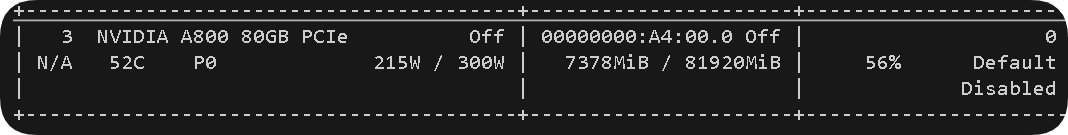


使用如下命令启动tensorboard服务，

tensorboard --logdir=./output

然后在浏览器中访问 http://localhost:6006 查看训练指标的可视化结果。

由于在服务器上，所以将文件下载下来，并在本地展示
注意：主要下载run目录下的检查点文件就行，不要下载整个目录，因为包含了lora权重文件。。

tensorboard上将记录各种详细信息
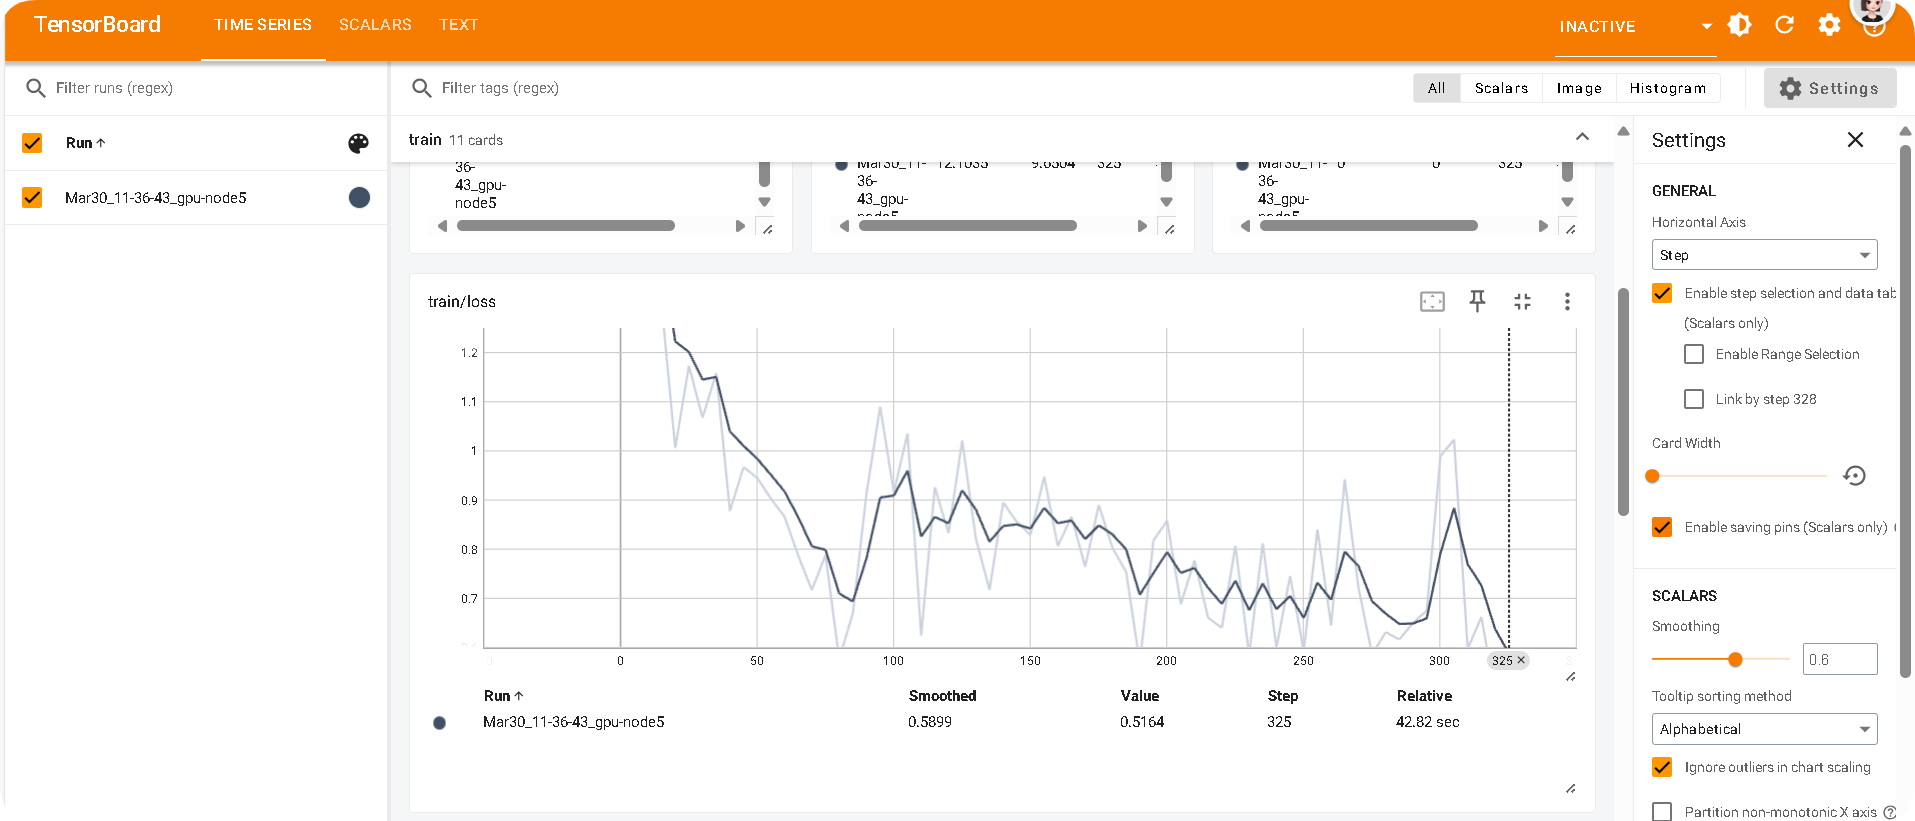

## 加载训练后的模型

In [3]:
!pwd

/home/shichaoxue/graduate


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,"

MODEL_PATH="/home/shichaoxue/models/Qwen2.5-0.5B-Instruct"
# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=False)
# 加载原始预训练模型
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, torch_dtype=torch.float16, device_map="auto", trust_remote_code=False)

# 定义微调后适配器模型的保存路径
peft_model_path = "./output/checkpoint-164"

# 加载适配器模型并应用到原始模型上
model = PeftModel.from_pretrained(model, peft_model_path)


/home/shichaoxue/anaconda3/envs/graduate/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [28]:
from datasets import Dataset
prompt="def add(a,b):\n"
messages=[{
            "role":"system",
            "content":"you are a helpful code assistant,please complete the provided python code",
        },
        {
            "role":"user",
            "content":prompt,
        },
        {
            "role":"assistant",
            "content":""
        }
        ]

input_text = tokenizer.apply_chat_template(messages, tokenize=False)
print(input_text)
print(input_text.replace("<|im_start|>assistant\n<|im_end|>","<|im_start|>assistant"))
input_text=input_text.replace("<|im_start|>assistant\n<|im_end|>","<|im_start|>assistant")

<|im_start|>system
you are a helpful code assistant,please complete the provided python code<|im_end|>
<|im_start|>user
def add(a,b):
<|im_end|>
<|im_start|>assistant
<|im_end|>

<|im_start|>system
you are a helpful code assistant,please complete the provided python code<|im_end|>
<|im_start|>user
def add(a,b):
<|im_end|>
<|im_start|>assistant



In [29]:
# 准备输入文本

inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs["input_ids"].to(model.device)
attention_mask = inputs["attention_mask"].to(model.device)

# Generate the output
output = model.generate(input_ids, attention_mask=attention_mask,max_new_tokens=512)

# 解码输出
output_text = tokenizer.decode(output[0], skip_special_tokens=False)
print(output_text)


<|im_start|>system
you are a helpful code assistant,please complete the provided python code<|im_end|>
<|im_start|>user
def add(a,b):
<|im_end|>
<|im_start|>assistant
    return a + b
<|im_end|>


In [30]:
output_text[output_text.find("assistant\n"):]

'assistant\n    return a + b\n<|im_end|>'

In [31]:
output_text.split("assistant\n")[1]

'    return a + b\n<|im_end|>'

In [32]:
# 合并适配器模型到基础模型
model = model.merge_and_unload()
# 定义保存路径
save_path = "./merged_model"
# 保存合并后的模型
model.save_pretrained(save_path)
# 保存分词器
tokenizer.save_pretrained(save_path)
print(f"模型已保存到 {save_path}")

模型已保存到 ./merged_model


# SFT理所应当只训练输出

In [1]:
from datasets import load_dataset,Dataset

dataset = load_dataset("json", data_files="./human-eval/data/human-eval-v2-20210705.jsonl",split='train')
print("#"+dataset['task_id'][0]+'\n'+dataset['prompt'][0]+'\n'+dataset['canonical_solution'][0]+'\n')
train_dataset = [
        dict(
            messages=[{
                        "role":"system",
                        "content":"you are a helpful code assistant",
                    },
                    {
                        "role":"user",
                        "content":prompt,
                    },
                    {
                        "role":"assistant",
                        "content":canonical_solution,
                    },]
        )
        for prompt,canonical_solution in zip(dataset['prompt'],dataset['canonical_solution'])
]
train_dataset = Dataset.from_list(train_dataset)
print(train_dataset[0]["messages"])

/home/shichaoxue/anaconda3/envs/graduate/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#HumanEval/0
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """

    for idx, elem in enumerate(numbers):
        for idx2, elem2 in enumerate(numbers):
            if idx != idx2:
                distance = abs(elem - elem2)
                if distance < threshold:
                    return True

    return False


[{'content': 'you are a helpful code assistant', 'role': 'system'}, {'content': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([

In [2]:
from transformers import AutoProcessor,AutoTokenizer

#自动加载tokenzier

MODEL_PATH="/home/shichaoxue/models/Qwen2.5-0.5B-Instruct"
processor = AutoProcessor.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
print(processor.apply_chat_template(train_dataset[0]["messages"],tokenize=False))

<|im_start|>system
you are a helpful code assistant<|im_end|>
<|im_start|>user
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """
<|im_end|>
<|im_start|>assistant
    for idx, elem in enumerate(numbers):
        for idx2, elem2 in enumerate(numbers):
            if idx != idx2:
                distance = abs(elem - elem2)
                if distance < threshold:
                    return True

    return False
<|im_end|>



In [3]:
texts = [processor.apply_chat_template(train_dataset[i]["messages"],tokenize=False)  
        for i in range(len(train_dataset))]
batch = processor(texts,return_tensors="pt",padding=True,truncation=True)
#padding后最后一条数据的attention_mask为： [1, 1, 1,  ..., 0, 0, 0]
batch

{'input_ids': tensor([[151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        ...,
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [4]:
labels=batch["input_ids"].clone()
labels[labels==tokenizer.pad_token_id]=-100 #-100为魔术word，写死的
batch["labels"]=labels
#注意label中 padding后最后一条数据的attention_mask为： [151644,   8948,    198,  ...,   -100,   -100,   -100]

#也就是这些被padding的部分，改成-100，不要去训练，不要去训练模型在这里接着生成pad_token
batch

{'input_ids': tensor([[151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        ...,
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[151644,   8948,    198,  ...,   -100,   -100,   -100],
        [151644,   8948,    198,  ...,   -100,   -100,   -100],
        [151644,   8948,    198,  ...,   -100,   -100,   -100],
        ...,
        [151644,   8948,    198,  ...,   -100,   -100,   -100],
        [151644,   8948,    198,  ...,   -100,   -100,   -100],
       

In [5]:
#显然， prompt+solution中，prompt部分也不需要训练，
#现在处理这件事情。

from trl import DataCollatorForCompletionOnlyLM,SFTConfig,SFTTrainer
from transformers import AutoProcessor
data_collator = DataCollatorForCompletionOnlyLM(response_template="assistant",tokenizer=tokenizer)

def collate_fn(examples):
    texts=[
        processor.apply_chat_template(examples[i]["messages"],tokenize=False)  
        for i in range(len(examples))
    ]
    batch = processor(texts,return_tensors="pt",padding=True,truncation=True,return_special_tokens_mask=True)
    # 提取 input_ids 和 attention_mask 组成新的字典
    input_dict = {
        "input_ids": batch["input_ids"],
        "attention_mask": batch["attention_mask"]
    }
    # print(input_dict)
      # 将字典转换为列表形式
    input_list = [{"input_ids": input_ids, "attention_mask": attn_mask} for input_ids, attn_mask in zip(input_dict["input_ids"], input_dict["attention_mask"])]
    return data_collator.torch_call(input_list)
batch = collate_fn(train_dataset)
batch

{'input_ids': tensor([[151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        ...,
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ..., 151643, 151643, 151643]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        ...,
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100]])}

In [6]:
batch['input_ids'][0]

tensor([151644,   8948,    198,   9330,    525,    264,  10950,   2038,  17847,
        151645,    198, 151644,    872,    198,   1499,  19496,   1159,   1759,
          1406,    750,    702,  12704,  22801,  47207,     25,   1759,  95381,
          1125,  12171,     25,   2224,      8,   1464,   1807,    510,    262,
          4210,   4248,    421,    304,   2661,   1140,    315,   5109,     11,
           525,    894,   1378,   5109,  12128,    311,   1817,   1008,   1091,
           198,    262,   2661,  12171,    624,    262,  12109,    702,  12704,
         22801,   2561,     16,     13,     15,     11,    220,     17,     13,
            15,     11,    220,     18,     13,     15,   1125,    220,     15,
            13,     20,    340,    262,   3557,    198,    262,  12109,    702,
         12704,  22801,   2561,     16,     13,     15,     11,    220,     17,
            13,     23,     11,    220,     18,     13,     15,     11,    220,
            19,     13,     15,     11, 

In [7]:
batch['labels'][0]

tensor([  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100, 

**通过上述对比发现， 终于正确做了padding了， 仅仅训练输出**

In [ ]:
import os
from transformers import AutoModelForCausalLM
from trl import SFTConfig,SFTTrainer
from peft import LoraConfig
os.environ["CUDA_VISIBLE_DEVICES"] = "3,"

MODEL_PATH="/home/shichaoxue/models/Qwen2.5-0.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    # quantization_config=BitsAndBytesConfig(load_in_8bit=True),
    device_map="auto",
    )


traing_args = SFTConfig(
    output_dir="./output",
    report_to="tensorboard",#支持tensorboard和wandb
    num_train_epochs=1,
    per_device_train_batch_size=1,
    logging_steps=1,  # 每10步记录一次日志
    save_steps=164,  # 每100步保存一次检查点
    learning_rate=2e-5  # 设置学习率
)
#注意下面新增加args
traing_args.remove_unused_columns=False 
traing_args.dataset_kwargs = {"skip_prepare_dataset":True}

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=[#all-linear
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    modules_to_save=["lm_head","embed_token"],#不加可能会保存失败,
    task_type="CAUSAL_LM",
)
trainer=SFTTrainer(
    model,
    peft_config=peft_config,
    train_dataset=train_dataset,
    data_collator=collate_fn, #注意这里新加的内容

    args=traing_args
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [10]:
trainer.train()

Step,Training Loss
1,0.800600
2,1.282800
3,1.296800
4,1.052200
5,0.804400
6,0.801900
7,0.493900
8,0.504700
9,0.549400
10,0.847200


TrainOutput(global_step=164, training_loss=0.5594228897698041, metrics={'train_runtime': 25.9597, 'train_samples_per_second': 6.317, 'train_steps_per_second': 6.317, 'total_flos': 103066270812672.0, 'train_loss': 0.5594228897698041})